In [1]:
from geopy.distance import geodesic
import numpy as np
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import random

class Ant:
    def __init__(self, distances, pheromones, alpha, beta):
        self.distances = distances
        self.pheromones = pheromones
        self.alpha = alpha
        self.beta = beta
        self.visited = set()
        self.path = []

    def choose_next_city(self, current_city):
        next_city = None
        max_probability = 0
        for city in range(len(self.distances)):
            if city not in self.visited:
                probability = self.pheromones[current_city, city] ** self.alpha * (1 / self.distances[current_city, city]) ** self.beta
                if probability > max_probability:
                    max_probability = probability
                    next_city = city
        return next_city

    def find_path(self, start_city):
        self.visited.add(start_city)
        self.path.append(start_city)
        current_city = start_city
        while len(self.visited) < len(self.distances):
            next_city = self.choose_next_city(current_city)
            self.visited.add(next_city)
            self.path.append(next_city)
            current_city = next_city
        return self.path

class ACO:
    def __init__(self, distances, alpha=1, beta=1, rho=0.1, num_ants=10, iterations=100):
        self.distances = distances
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.num_ants = num_ants
        self.iterations = iterations
        self.pheromones = np.ones((len(distances), len(distances)))

    def run(self):
        G = nx.Graph()
        for i in range(len(self.distances)):
            for j in range(len(self.distances)):
                if i != j:
                    G.add_edge(i, j, weight=self.distances[i, j])
        pos = nx.spring_layout(G)
        shortest_path = None
        shortest_distance = float('inf')
        for _ in range(self.iterations):
            ants = [Ant(self.distances, self.pheromones, self.alpha, self.beta) for _ in range(self.num_ants)]
            for ant in ants:
                start_city = random.randint(0, len(self.distances) - 1)
                path = ant.find_path(start_city)
                distance = calculate_path_distance(path, self.distances)
                if distance < shortest_distance:
                    shortest_path = path
                    shortest_distance = distance
                update_pheromones(self.pheromones, self.distances, ants, self.rho)
        nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3)
        nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
        if shortest_path:
            shortest_path_indices = shortest_path
            if shortest_path_indices:
                shortest_path_nodes = {node: pos[node] for node in shortest_path_indices}
                nx.draw_networkx_nodes(G, shortest_path_nodes, node_size=80, node_color='red')
        nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')
        plt.title(f"Shortest path: {shortest_path}")
        plt.show()
        return shortest_path, shortest_distance

def calculate_path_distance(path, distances):
    distance = 0
    for i in range(len(path) - 1):
        distance += distances[path[i], path[i + 1]]
    return distance

def update_pheromones(pheromones, distances, ants, rho):
    for i, j in itertools.product(range(len(distances)), range(len(distances))):
        pheromones[i, j] *= (1 - rho)  # Evaporation
        for ant in ants:
            if i in ant.path and j in ant.path and i != j:
                pheromones[i, j] += 1 / calculate_path_distance(ant.path, distances)  # Pheromone update
                
def fix_latitude(coor):
    if coor > 90:
        return coor - 180
    elif coor < -90:
        return coor + 180
    else:
        return coor

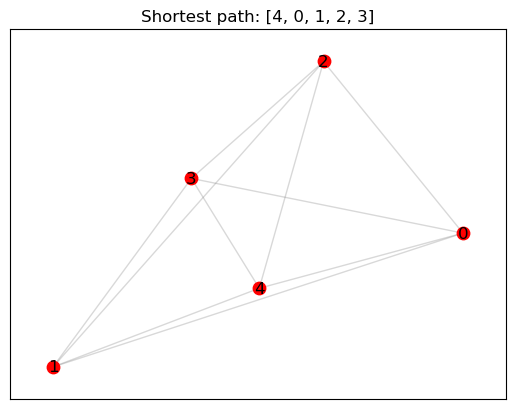

Shortest path: [4, 0, 1, 2, 3]
Shortest distance: 933
Total distance via shortest path: 8281895.57 m


In [2]:
distances = np.array([
    [0, 10, 175, 400, 500],  # Titik 0 Jarak Indonesia ke negara lainnya 
    [10, 0, 23, 350, 600],    # Titik 1 Jarak Singapura ke negara lainnya 
    [175, 23, 0, 400, 500],    # Titik 2 Jarak Malaysia ke negara lainnya 
    [400, 350, 400, 0, 800],    # Titik 3 Jarak Jepang ke negara lainnya 
    [500, 600, 500, 800, 0]    # Titik 4 Jarak Australia ke negara lainnya 
])

route = [
    (113.9213, -0.7893),  # Koordinat Indonesia Titik 0
    (103.8198, 1.3521),  # Koordinat Singapura Titik 1
    (101.9758, 4.2105),  # Koordinat Malaysia Titik 2
    (138.2529, 36.2048),  # Koordinat Jepang Titik 3
    (133.7751, -25.2744)   # Koordinat Australia Titik 4
]

fixed_route = [(fix_latitude(lat), lon) for lat, lon in route]

alpha = 1.0
beta = 5.0
rho = 0.1
num_ants = 10
iterations = 100

aco = ACO(distances, alpha, beta, rho, num_ants, iterations)
shortest_path, shortest_distance = aco.run()

print(f"Shortest path: {shortest_path}")
print(f"Shortest distance: {shortest_distance}")

shortest_path_coordinates = [fixed_route[i] for i in shortest_path]
total_shortest_path_distance = 0
for i in range(len(shortest_path_coordinates) - 1):
    point1 = shortest_path_coordinates[i]
    point2 = shortest_path_coordinates[i + 1]
    distance = geodesic(point1, point2).meters
    total_shortest_path_distance += distance
print(f"Total distance via shortest path: {total_shortest_path_distance:.2f} m")

### Didapatkan Hasil Untuk Perjalanan Terpendek antar Negara Yang bisa Ditempuh Ialah
Dari Negara Australia (Titik 4) menuju Indonesia (Titik 0) setelah itu menuju ke Singapura (Titik 1) setelah itu menuju ke Malaysia (Titik 2) setelah itu menuju ke Jepang (Titik 3)

Dikarenakan jarak yang paling pendek yaitu : 500 + 10 + 23 + 400 = 933